# Run the Force-directed Structure Generator with an Initial Relaxation
As before but we relax the oxygen bonding framework with a simple potential: $1/r^6$ repulsion and a harmonic potential for hydrogen bonds.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.inversion.force import convert_directed_graph_to_xyz
from hydronet.inversion import evaluate_inversion
from hydronet.data import atoms_from_dict
from scipy.stats import kendalltau
from random import choices, seed
from tqdm import tqdm
import pandas as pd
import numpy as np
import json

## Perform the analysis on all structures.
Take the known geometry, make the graph, invert the graph and report how different the new geometry is

In [2]:
function = lambda x: convert_directed_graph_to_xyz(x, relax_with_harmonic=True, repulsion_str=10)

In [3]:
results = []
seed(123)
with open('../benchmark_clusters.json') as fp:
    lines = fp.readlines()
#    lines = choices(lines, k=4)
    for line in tqdm(lines):
        record = json.loads(line)
        result = evaluate_inversion(function, atoms_from_dict(record))        
        record.update(result)
        results.append(record)

100%|██████████| 2270/2270 [1:02:23<00:00,  1.65s/it]


In [4]:
results = pd.DataFrame(results)
results.head()

,z,n_water,n_atoms,atom,coords,energy,source,invert_time,unrelaxed_energy,relax_time,total_time,final_energy,energy_diff,is_isometric,adj_difference,rmsd
0,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[16.22398533, 11.83660939, -10.64692684], [16...",-236.543072,best,0.093068,143.680445,0.989961,1.083028,-236.542439,0.000633,True,0,180.311272
1,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[-4.89073277, -6.3163085, 5.12766981], [-4.28...",-236.547806,best,0.056955,85.726735,1.257129,1.314083,-231.577877,4.969934,False,4,81.563651
2,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[-2.35686894, -4.33661624, 6.51201207], [-2.4...",-236.561279,best,0.064863,-79.353090,1.189281,1.254143,-235.042022,1.519257,False,2,60.008775
3,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[15.43519603, 3.81546594, -16.89504925], [15....",-236.572013,best,0.061285,-17.432807,1.587649,1.648934,-230.590972,5.981041,False,4,186.878041
4,"[8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, ...",22,66,"[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[[-3.52119126, -1.80291181, -1.00666364], [-4....",-236.574054,best,0.049786,-56.945884,1.804415,1.854201,-228.334723,8.239331,False,2,12.674591


Save the results. Note that I'm excluding the coordinates of the original structure, which are no longer needed

In [5]:
results.drop(columns=['z', 'atom', 'coords']).to_csv('force-directed-with-harmonic.csv', index=False)

In [6]:
results = pd.read_csv('force-directed-with-harmonic.csv')

## Assess the Results
I want to see how often we get the 'correct' graph or one that is energetically degenerate under different conditions

## How different are the graphs?
See if we recover the initial graph exactly and, if not, how many bonds are missing.

In [7]:
print(f'Overall isometric success rate: {results["is_isometric"].mean()*100:.1f}%')

Overall isometric success rate: 25.5%


See by system size

Text(0.5, 0, 'Cluster Size')

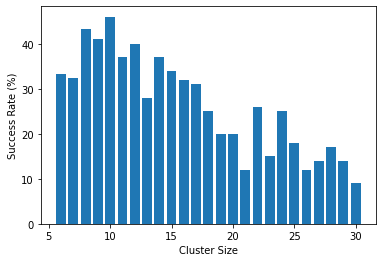

In [8]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['is_isometric'].mean()
ax.bar(by_size.index, by_size * 100)

ax.set_ylabel('Success Rate (%)')
ax.set_xlabel('Cluster Size')

Success rate is not great. We achieve a rate of <30% for large clusters.

Text(0.5, 0, 'Cluster Size')

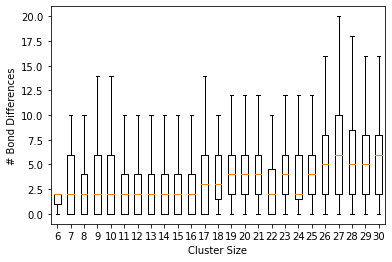

In [9]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['adj_difference'].apply(list)
ax.boxplot(by_size.tolist(), positions=by_size.index, showfliers=False)

ax.set_ylabel('# Bond Differences')
ax.set_xlabel('Cluster Size')

## How large are the energy differences? 
Are they large in absolute magnitude? Large enough to interfere with ranking

In [10]:
results['energy_diff_per_water'] = results['energy_diff'] / results['n_water']

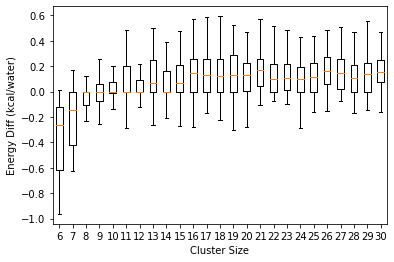

In [11]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['energy_diff_per_water'].apply(list)
ax.boxplot(by_size.tolist(), positions=by_size.index, showfliers=False)

ax.set_ylabel('Energy Diff (kcal/water)')
ax.set_xlabel('Cluster Size')
fig.savefig('temp.svg')

Text(0.5, 0, 'Cluster Size')

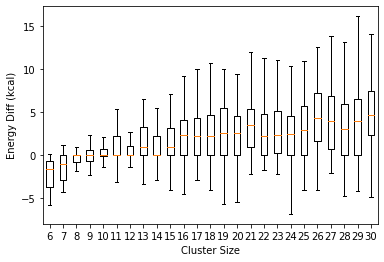

In [12]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['energy_diff'].apply(list)
ax.boxplot(by_size.tolist(), positions=by_size.index, showfliers=False)

ax.set_ylabel('Energy Diff (kcal)')
ax.set_xlabel('Cluster Size')

Energy difference can be quite large and are easily in the ~0.1 kcal/water range.

Measure ranking performance with Kendal tau

In [13]:
results['new_energy'] = results['energy'] + results['energy_diff']

Text(0.5, 0, 'Cluster Size')

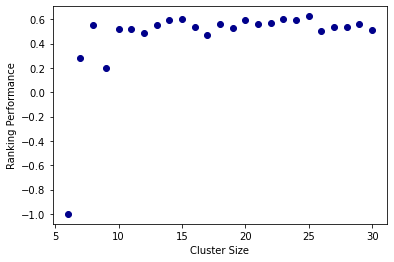

In [14]:
fig, ax = plt.subplots()

for size, group in results.groupby('n_water'):
    rank_val = kendalltau(group['energy'], group['new_energy'])
    ax.scatter([size], [rank_val.correlation], color='darkblue')

ax.set_ylabel('Ranking Performance')
ax.set_xlabel('Cluster Size')

The ranking performance is better than random, but not great. It seems that we expect 50% of pairs to be in the correct order.